# __기후 데이터를 활용한 전력 사용량 예측__

## __1. 문제정의__

### __분석목표__
* 60개 건물의 2020년 8월 24일부터 8월 31일까지의 1시간 단위 전력 사용량을 예측합니다.

* 이를 위해 2020년 6월 1일부터 8월 23일까지의 과거 전력 사용량과 기후 데이터를 활용하여 지도학습 회귀 모델을 구축합니다.

### __예측변수__
* 건물 관련 변수
    * 건물 번호
    * 비전기냉방설비운영
    * 태양광보유
<br>
<br>
* 기후 데이터 
    * 기온
    * 풍속
    * 습도
    * 강수량
    * 일조
<br>
<br>
* 날짜정보

In [1]:
# 데이터 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
import matplotlib.font_manager as fm

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]
font_list
plt.rcParams['font.family'] = 'Malgun Gothic'

train = pd.read_csv('../data/train.csv', encoding='cp949')
test = pd.read_csv('../data/test.csv', encoding='cp949')

# 데이터 미리보기
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


## __2. 데이터 탐색 및 전처리__

### __데이터 개요__

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [3]:
# float형 변수가 많아서 describe 함수를 통해 수치형 변수들의 통계 정보 파악 
train.describe()

,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
count,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000
mean,30.500000,2324.830866,24.251713,2.151641,80.169848,0.514989,0.213533,0.683333,0.483333
std,17.318173,2058.999326,3.407902,1.514475,15.525862,2.624505,0.370517,0.465178,0.499724
min,1.000000,0.000000,11.100000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,15.750000,1055.268000,21.800000,1.100000,70.000000,0.000000,0.000000,0.000000,0.000000
50%,30.500000,1700.352000,24.200000,1.900000,84.000000,0.000000,0.000000,1.000000,0.000000
75%,45.250000,2780.487000,26.500000,2.900000,93.000000,0.000000,0.300000,1.000000,1.000000
max,60.000000,17739.225000,36.300000,20.100000,100.000000,81.500000,1.000000,1.000000,1.000000


In [4]:
# 변수를 분석하기 쉽게 컬럼명을 변경
cols = ['num', 'date_time', 'power', 'temp', 'wind','hum' ,'prec', 'sun', 'non_elec', 'solar']
train.columns = cols

cols.remove('power')
test.columns = cols

In [5]:
train.head()

,num,date_time,power,temp,wind,hum,prec,sun,non_elec,solar
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [6]:
test.head()

,num,date_time,temp,wind,hum,prec,sun,non_elec,solar
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### __결측치 및 이상치 처리__

#### __이상치__

강수량과 일조량의 경우 대부분이 0 값을 가지고 있어, 일부 값들이 이상치로 뷴류되나, 둘 다 전력사용량 예측에 중요한 변수이므로 변환없이 사용하였습니다.

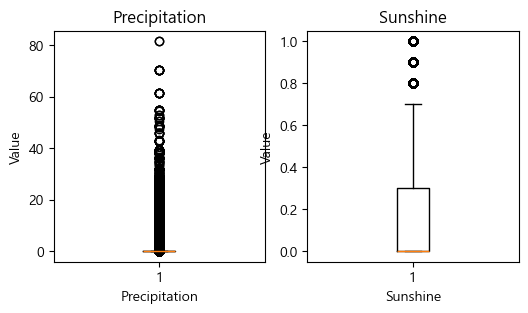

In [7]:
plt.figure(figsize = (6,3))
plt.subplot(1,2,1)
plt.boxplot(train['prec'])
plt.title('Precipitation') 
plt.xlabel('Precipitation')  
plt.ylabel('Value')

plt.subplot(1,2,2)
plt.boxplot(train['sun'])
plt.title('Sunshine')
plt.xlabel('Sunshine')
plt.ylabel('Value')  

plt.show()

#### __결측치__

train 데이터에서는 결측치가 존재하지 않지만, test 데이터에서는 결측치가 상당수 존재합니다.

In [8]:
train.isnull().sum()

num          0
date_time    0
power        0
temp         0
wind         0
hum          0
prec         0
sun          0
non_elec     0
solar        0
dtype: int64

In [9]:
test.isnull().sum()

num             0
date_time       0
temp         6720
wind         6720
hum          6720
prec         8400
sun          6720
non_elec     7784
solar        8456
dtype: int64

test데이터에서 건물번호별로 비전기냉방설비운영과 태양광보유여부는 train 데이터의 건물번호별 값을 동일하게 따를 것으로 가정하여, test데이터의 해당 결측값을 train데이터 기반으로 처리합니다.

In [10]:
non_elec_num = {}
solar_num = {}
count = 0

step = len(train)//60

for i in range(0, len(train), step):
    count += 1
    non_elec_num[count] = train.loc[i,'non_elec']
    solar_num[count] = train.loc[i,'solar']

for i in range(len(test)):
    test.loc[i, 'non_elec'] = non_elec_num[test['num'][i]]
    test.loc[i, 'solar'] = solar_num[test['num'][i]]

test데이터의 일부를 확인한 결과, 결측치가 규칙적으로 발생하는 패턴을 발견하였습니다.

'prec'변수는 0시에 값이 존재하고, 1시부터 5시까지 결측치가 발생하며, 6시에 값이 존재하고, 7~11시까지 결측치가 발생하는 패턴이 나타납니다.

다른 변수들인 'temp', 'wind', 'hum', 'sun' 또한 0시에 값이 존재하고, 1시부터 2시까지 결측치가 발생하며, 3시에 값이 존재하고, 4~5시까지 결측치가 반복되는 패턴을 보입니다.

이를 시각적으로 확인하기 위해 코드를 작성해보았습니다.

In [11]:
test.head(30)

,num,date_time,temp,wind,hum,prec,sun,non_elec,solar
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,0.0,0.0
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,0.0,0.0
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,0.0,0.0
5,1,2020-08-25 05,NaN,NaN,NaN,NaN,NaN,0.0,0.0
6,1,2020-08-25 06,26.1,1.3,83.0,0.0,0.0,0.0,0.0
7,1,2020-08-25 07,NaN,NaN,NaN,NaN,NaN,0.0,0.0
8,1,2020-08-25 08,NaN,NaN,NaN,NaN,NaN,0.0,0.0
9,1,2020-08-25 09,28.8,1.2,77.0,NaN,1.1,0.0,0.0


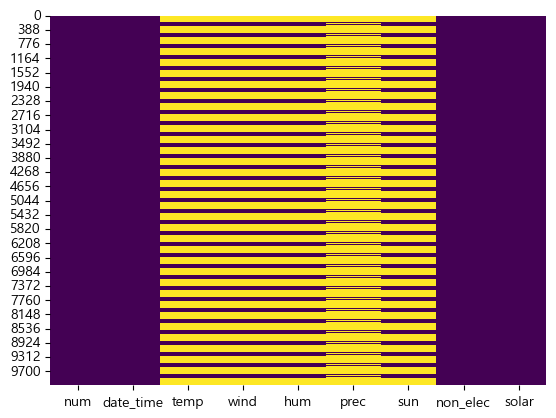

In [12]:
sns.heatmap(test.isnull(), cbar = False, cmap='viridis')
plt.show()

따라서 결측치를 이전 값으로 채워지도록 코드를 작성하였습니다.

데이터가 매우 커서 데이터 프레임을 사용하면 오류가 발생할 수 있기 때문에, 'values' 속성을 사용하여 배열 기반 처리를 적용하였습니다.

In [13]:
test_values = test.values

# 'prec' 변수만 처리
prec_col_idx = test.columns.get_loc('prec')
for i in range(test.shape[0]-5):
    if (pd.isnull(test_values[i + 1, prec_col_idx]) and pd.isnull(test_values[i+2, prec_col_idx]) and 
        pd.isnull(test_values[i + 3, prec_col_idx]) and pd.isnull(test_values[i+4, prec_col_idx]) and
        pd.isnull(test_values[i + 5, prec_col_idx])):
        
            test_values[i + 1, prec_col_idx] = test_values[i, prec_col_idx]
            test_values[i + 2, prec_col_idx] = test_values[i, prec_col_idx]
            test_values[i + 3, prec_col_idx] = test_values[i, prec_col_idx]
            test_values[i + 4, prec_col_idx] = test_values[i, prec_col_idx]
            test_values[i + 5, prec_col_idx] = test_values[i, prec_col_idx]

for col_idx in range(test.shape[1]):
    if  test.columns[col_idx] == 'prec':
        continue
        
    for i in range(test.shape[0] - 2):
        if pd.isnull(test_values[i + 1, col_idx]) and pd.isnull(test_values[i+2, col_idx]):
            test_values[i + 1, col_idx] = test_values[i, col_idx]
            test_values[i + 2, col_idx] = test_values[i, col_idx]


test = pd.DataFrame(test_values, columns = test.columns)
test.head(30)

,num,date_time,temp,wind,hum,prec,sun,non_elec,solar
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,0.0,0.0
1,1,2020-08-25 01,27.8,1.5,74.0,0.0,0.0,0.0,0.0
2,1,2020-08-25 02,27.8,1.5,74.0,0.0,0.0,0.0,0.0
3,1,2020-08-25 03,27.3,1.1,78.0,0.0,0.0,0.0,0.0
4,1,2020-08-25 04,27.3,1.1,78.0,0.0,0.0,0.0,0.0
5,1,2020-08-25 05,27.3,1.1,78.0,0.0,0.0,0.0,0.0
6,1,2020-08-25 06,26.1,1.3,83.0,0.0,0.0,0.0,0.0
7,1,2020-08-25 07,26.1,1.3,83.0,0.0,0.0,0.0,0.0
8,1,2020-08-25 08,26.1,1.3,83.0,0.0,0.0,0.0,0.0
9,1,2020-08-25 09,28.8,1.2,77.0,0.0,1.1,0.0,0.0


In [14]:
test.isnull().sum()

num          0
date_time    0
temp         0
wind         0
hum          0
prec         0
sun          0
non_elec     0
solar        0
dtype: int64

### __범주형 변수 처리__

In [15]:
train['num'] = train['num'].astype('category')

train['non_elec'] = train['non_elec'].astype('category')
train['non_elec'].value_counts()

train['solar'] = train['solar'].astype('category')
train['solar'].value_counts()

solar
0.0    63240
1.0    59160
Name: count, dtype: int64

## __3. 시각화__

### 시간에 따른 주기성 확인

시계열 데이터임을 고려하여 특정 건물(건물번호 8번)의 전력사용량을 기반으로 시간 순서대로 분할하고, 이를 시각화 해보았습니다.

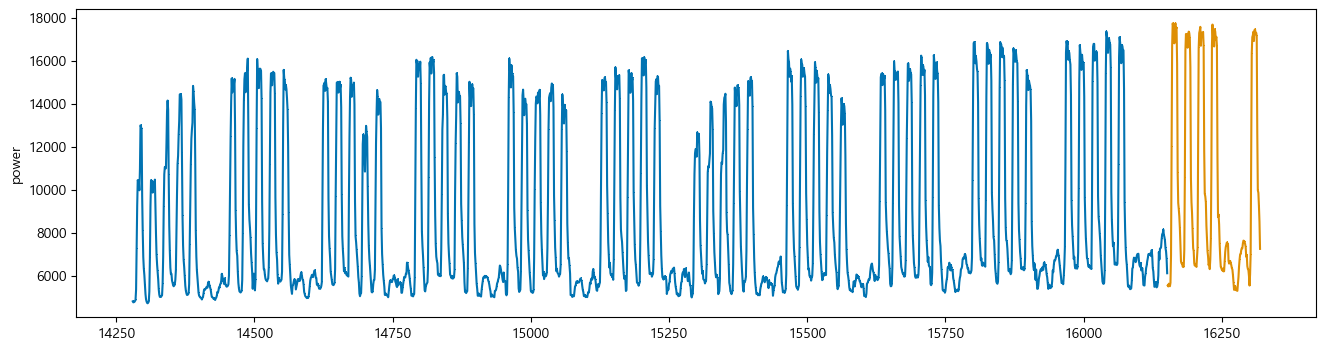

In [16]:
y = train.loc[train.num == 8, 'power']
x = train.loc[train.num == 8]
    
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)
    
plot_series(y_train, y_valid, markers = [',',','])
plt.show()

이 그래프는 x축이 시간, y축이 전력사용량을 나타냅니다. 

그래프에서 특정 시간 구간에서 주기적인 전력 사용량 패턴이 관찰됩니다.특정 시간대에 전력 사용이 증가하고, 다시 감소하는 규칙적인 변화가 반복 되는 것으로 보입니다.

이러한 특징을 통해 건물이 사무실일 가능성을 보여줍니다. 평일에는 오전 9시부터 오후 5시까지 전력사용량이 증가하고, 이후 감소하며, 주말에는 상대적으로 낮은 전력사용량이 관찰됩니다.

따라서 시간대와 요일은 전력 사용량을 예측하는 데 있어 중요한 변수로 작용할 수 있습니다. 이를 바탕으로 유사한 전력 사용 패턴을 보이는 건물 간 군집화를 고려할 수 있습니다.

## __4. 파생 변수 생성__

#### __날짜관련 변수 추가__

In [17]:
# 날짜는 전력 사용량에 중요한 영향을 미치는 변수이므로
# date_time변수를 월, 일, 요일, 시간으로 세분화하여 정확성을 높이고자 하였다.

train['date_time'] = pd.to_datetime(train['date_time'])
train['hour'] = train['date_time'].dt.hour
train['month'] = train['date_time'].dt.month
train['day'] = train['date_time'].dt.day
train['weekday'] = train['date_time'].dt.weekday # 요일을 추출(0 = 월요일, 6=일요일)

#### __공휴일 변수 추가__

In [18]:
train['holiday'] = train.apply(lambda x : 0 if x['weekday']<5 else 1, axis = 1)
# 8월 17일과 18일은 공휴일이므로 주말변수를 1로
train.loc[('2020-08-17' <= train.date_time) & (train.date_time < '2020-08-18'), 'holiday'] = 1

### __불쾌지수 변수 추가__

전력사용량 예측에서 냉방 기기 사용은 중요한 요소로, 기온과 습도를 결합한 불쾌지수를 추가하여 사람들이 느끼는 기후 조건을 보다 정확하게 반영할 수 있을 것으로 판단하였습니다.

불쾌지수(Heat Index)는 기온(T)과 습도(H)를 결합한 값으로, 다음과 같이 계산됩니다.
$ HI = 0.81 \times T + 0.01 \times H \times (0.99 \times T - 14.3) + 46.3$

이를 바탕으로 불쾌지수 변수를 추가하였습니다.

In [19]:
def cal_heat_index(T, H):
    HI = 0.81 * T + 0.01 * H * (0.99 * T - 14.3) + 46.3
    return HI

train['heat_index'] = train.apply(lambda row: cal_heat_index(row['temp'], row['hum']), axis=1)

## __5. 시각화 추가__


### 용도가 비슷한 건물끼리 군집화

__건물의 용도는 전력사용량에 큰 영향을 미칠 것입니다. 예를 들어, 회사 사무실은 평일 9시부터 17시까지 전력사용량이 많고, 가정용 건물은 주말에 전력 사용량이 많을 것입니다. 이처럼 건물의 용도에 따라 전력사용량의 패턴이 달라질 수 있습니다.__

__하지만 일부 건물들은 전력 소비 패턴이 비슷할 수 있으며, 이를 군집화하면 유사한 패턴을 가진 건물들을 그룹화하여 전력사용량 예측 모델 개선하는데 큰 도움이 될 것입니다. 따라서 용도가 비슷한 건물들끼리 군집화를 진행하였습니다.__

__6월1일부터 8월 23일까지의 기간동안 각 건물에 대해 특정 시간대와 요일에 해당하는 전력사용량의 중앙값을 이용하여 군집화를 진행하였습니다.__

__1시간 단위로 군집화를 진행할 경우, 데이터의 복잡성이 증가할 수 있다고 판단하여, 데이터를 간소화하고 효율성을 높이기 위해 3시간 단위로 묶어 군집화를 진행하였습니다.__

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

train['hour_by_3'] = train ['hour']//3 # 3시간 단위로 나눔

cluster_train = train.copy()
cluster = cluster_train.pivot_table(index='num', columns=['weekday','hour_by_3'], values='power', aggfunc='median')

cluster_trains = pd.DataFrame(cluster)
cluster_trains.head()

C:\Users\ehdgu\AppData\Local\Temp\ipykernel_19500\301510349.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  cluster = cluster_train.pivot_table(index='num', columns=['weekday','hour_by_3'], values='power', aggfunc='median')


weekday           0                                                       \
hour_by_3         0         1         2            3         4         5   
num                                                                        
1          8541.288  8499.816  8506.944  8613.216000  8643.024  8659.224   
2           986.580   982.692  1346.868  1797.552000  1813.104  1709.748   
3          3240.648  3248.316  3352.212  3380.174525  3371.004  3400.488   
4           362.016   328.752   333.936   924.912000  1136.160  1098.144   
5          2922.048  2750.112  2265.408  2929.824000  2778.624  2641.680   

weekday                               1            ...         5            \
hour_by_3         6         7         0         1  ...         6         7   
num                                                ...                       
1          8585.352  8573.040  8522.820  8457.696  ...  8565.264  8567.532   
2          1216.296  1056.240   996.786   982.368  ...  1090.908  1023.516   
3          3322.836  3279.960  3247.776  3253.824  ...  3260.790  3249.234   
4           729.648   413.424   345.168   303.480  ...   773.712   441.936   
5          2694.384  2960.496  2739.960  2599.560  ...  2768.904  3045.384   

weekday           6                                                        \
hour_by_3         0         1            2         3          4         5   
num                                                                         
1          8525.412  8493.336  8474.220000  8490.096  8529.9480  8558.460   
2           995.652   985.446  1034.046000  1083.294  1100.4660  1116.342   
3          3307.824  3314.844  3294.216000  3220.722  3226.4145  3255.948   
4           358.560   325.080   365.230588  1042.848  1202.4720  1190.160   
5          3016.872  2889.000  2086.128000  2316.168  2427.1920  2452.896   

weekday                        
hour_by_3         6         7  
num                            
1          8565.588  8584.380  
2          1078.758  1015.416  
3          3259.710  3258.468  
4           751.896   438.480  
5          2585.952  3056.184  

[5 rows x 56 columns]

__각 건물의 전력사용량 데이터를 정규화__

각 건물별로 전력 사용량을 해당 건물에서의 최대값으로 나누어 데이터를 0과 1사이로 스케일링합니다.

이를 통해, 건물간 전력 사용량의 차이를 최소화하고, 비슷한 패턴을 가진 건물들 간의 비교를 용이하게 만듭니다.

In [21]:
cluster_trains = []
for i in range(60):
    cluster_trains.append(cluster.iloc[i,:]/cluster.iloc[i,:].max())

cluster_trains=pd.DataFrame(cluster_trains)
cluster_trains.head()

weekday           0                                                    \
hour_by_3         0         1         2         3         4         5   
1          0.986380  0.981591  0.982414  0.994687  0.998129  1.000000   
2          0.540709  0.538578  0.738169  0.985173  0.993696  0.937051   
3          0.948716  0.950961  0.981377  0.989563  0.986879  0.995510   
4          0.235526  0.213884  0.217257  0.601743  0.739179  0.714446   
5          0.878556  0.826861  0.681127  0.880894  0.835433  0.794259   

weekday                               1            ...         5            \
hour_by_3         6         7         0         1  ...         6         7   
1          0.991469  0.990047  0.984248  0.976727  ...  0.989149  0.989411   
2          0.666607  0.578887  0.546302  0.538400  ...  0.597887  0.560952   
3          0.972777  0.960225  0.950803  0.952574  ...  0.954613  0.951230   
4          0.474705  0.268971  0.224564  0.197442  ...  0.503373  0.287521   
5          0.810105  0.890116  0.823808  0.781595  ...  0.832511  0.915638   

weekday           6                                                    \
hour_by_3         0         1         2         3         4         5   
1          0.984547  0.980843  0.978635  0.980468  0.985071  0.988363   
2          0.545681  0.540087  0.566723  0.593714  0.603125  0.611826   
3          0.968382  0.970438  0.964399  0.942883  0.944549  0.953195   
4          0.233277  0.211495  0.237617  0.678471  0.782322  0.774311   
5          0.907066  0.868619  0.627224  0.696389  0.729770  0.737498   

weekday                        
hour_by_3         6         7  
1          0.989187  0.991357  
2          0.591228  0.556512  
3          0.954297  0.953933  
4          0.489179  0.285273  
5          0.777504  0.918886  

[5 rows x 56 columns]

__덴드로그램__

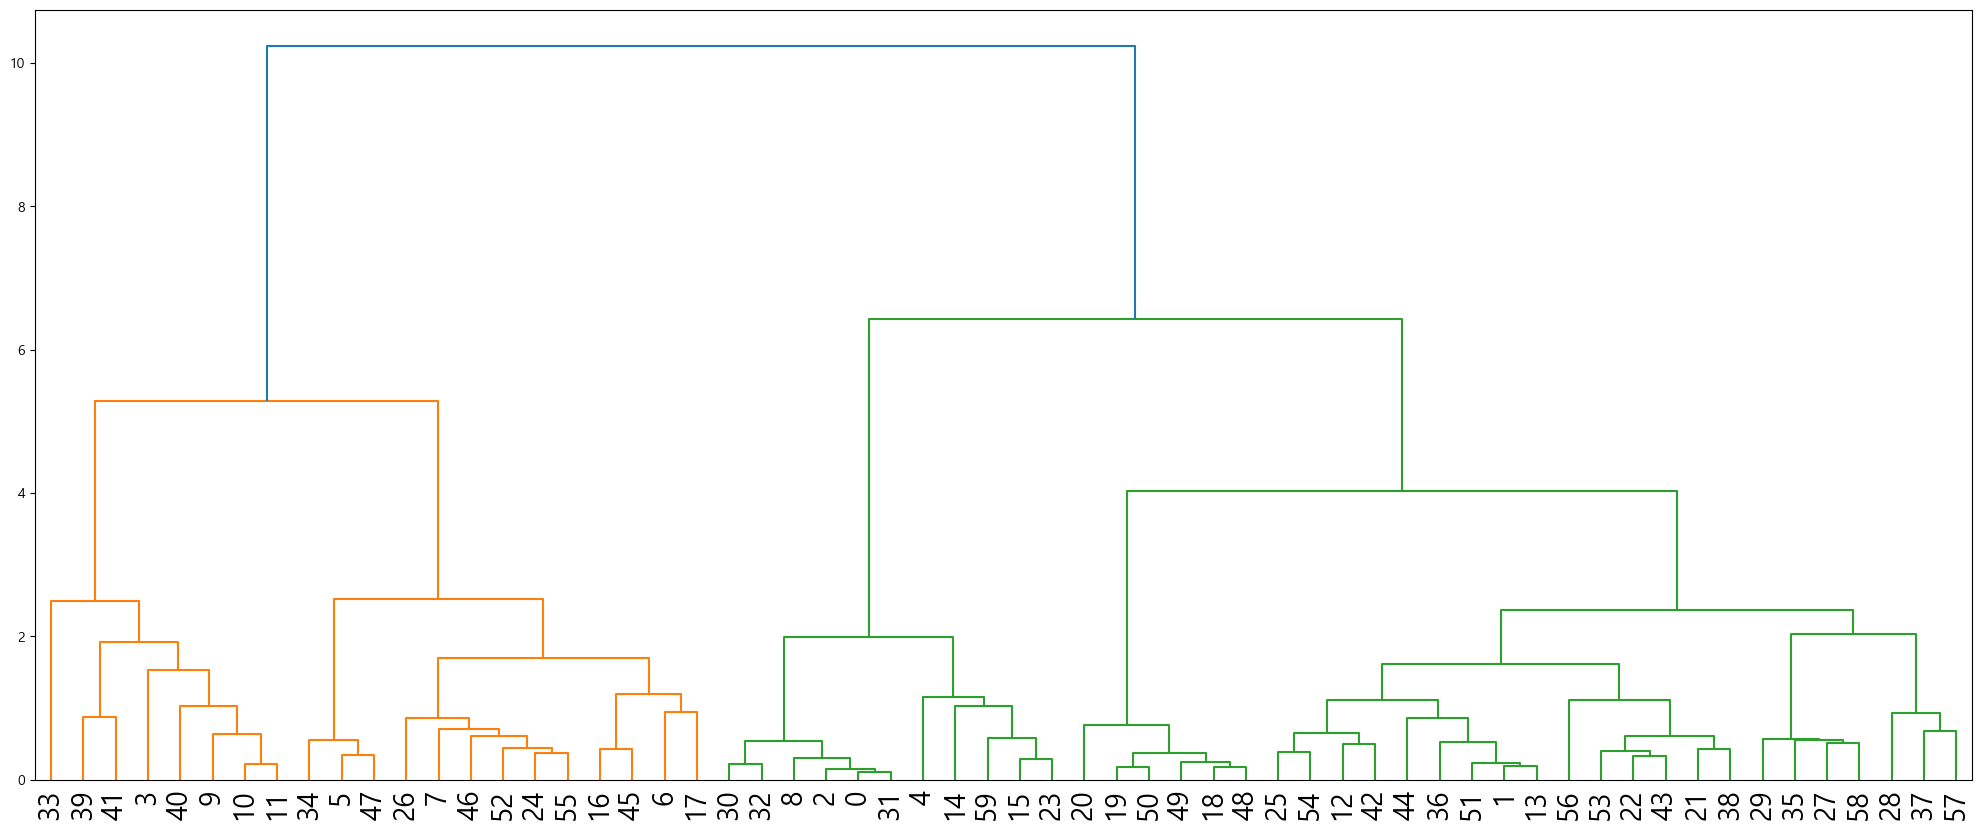

In [22]:
from scipy.cluster.hierarchy import dendrogram, ward
from matplotlib import pyplot as plt

linkage_array = ward(cluster_trains)

fig = plt.figure(figsize=(25, 10))
dendrogram(linkage_array, p=5, leaf_rotation=90, leaf_font_size=20)
plt.show()

__k-means__

C:\Users\ehdgu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


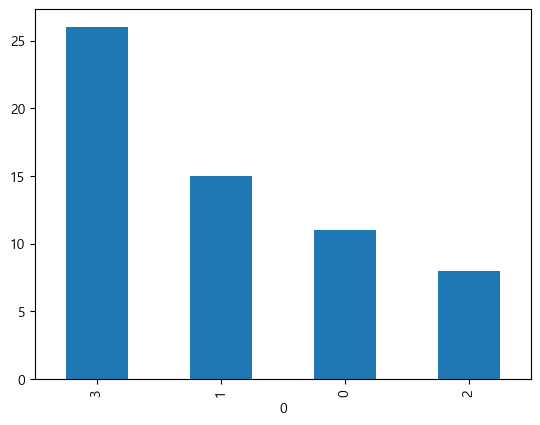

In [23]:
from sklearn.cluster import KMeans

model = KMeans(init="k-means++",n_clusters=4, random_state=0,algorithm='lloyd')

cluster=model.fit(cluster_trains)

cluster = model.labels_
pd.DataFrame(cluster)[0].value_counts().plot.bar()

cluster_map = {i+1 : c for i, c in enumerate(cluster)}
train['cluster'] = train['num'].map(cluster_map)
train['cluster'] = train['cluster'].astype('category')

__히트맵__

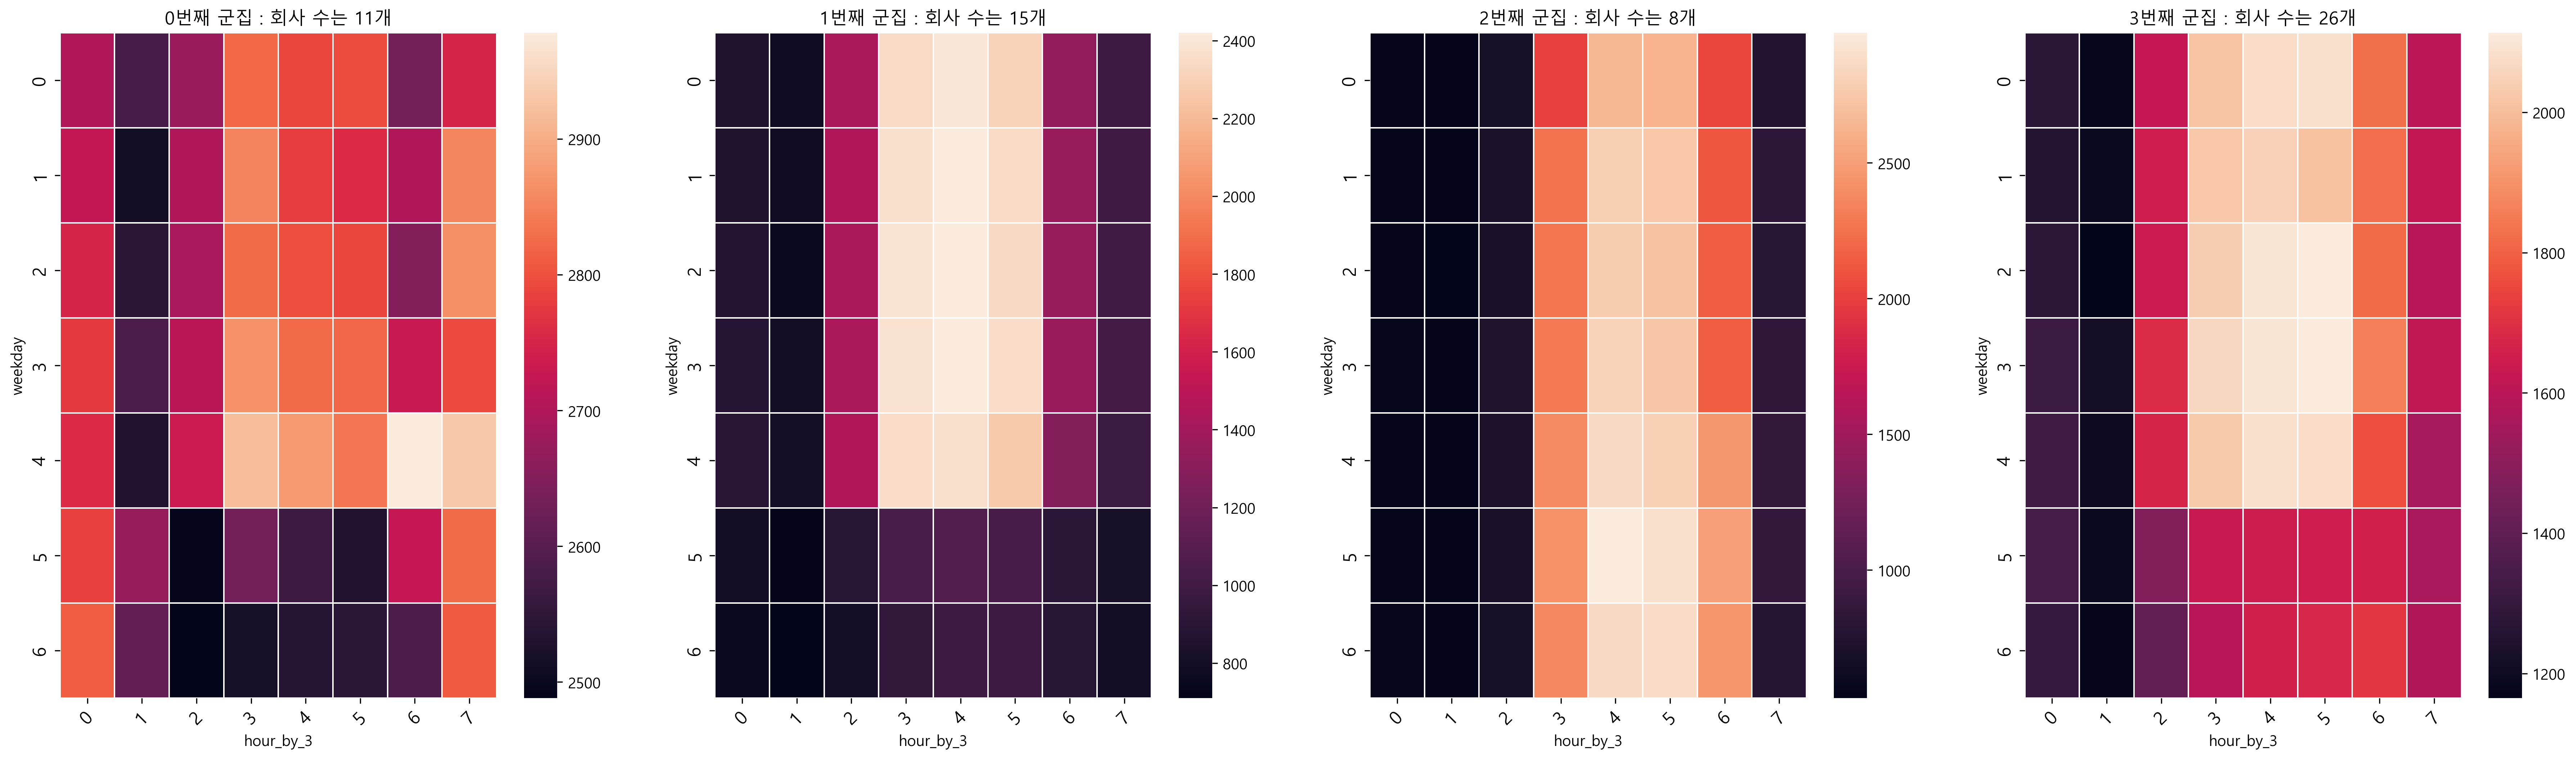

In [24]:
figure, ((ax1,ax2,ax3,ax4)) = plt.subplots(nrows=1, ncols=4)
figure.set_size_inches(30,8, forward=True)

figure.dpi = 300

figure_axes = pd.array([ax1,ax2,ax3,ax4])

for k, ax in enumerate(figure_axes):
    heatmap_data = train[train['cluster']==k].groupby(['weekday','hour_by_3'])['power'].median().reset_index()
    heatmap_data_pivot = heatmap_data.pivot(index = 'weekday', columns = 'hour_by_3', values = 'power')
    
    sns.heatmap(heatmap_data_pivot, ax=ax, fmt='0.2f', linewidths=0.5)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


    fig.tight_layout() 
    ax.set(title="{}번째 군집 : 회사 수는 {}개".format(k, len(train[train['cluster']==k]['num'].unique())))

## __6. 분석 준비__

### 분석을 위해 test데이터에 대해서도 train과 같은 처리를 진행한다

In [25]:
train.columns

Index(['num', 'date_time', 'power', 'temp', 'wind', 'hum', 'prec', 'sun',
       'non_elec', 'solar', 'hour', 'month', 'day', 'weekday', 'holiday',
       'heat_index', 'hour_by_3', 'cluster'],
      dtype='object')

test데이터의 데이터 타입이 object로 되어 있기 때문에 수치형으로 변환을 진행한다.

In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   num        10080 non-null  object
 1   date_time  10080 non-null  object
 2   temp       10080 non-null  object
 3   wind       10080 non-null  object
 4   hum        10080 non-null  object
 5   prec       10080 non-null  object
 6   sun        10080 non-null  object
 7   non_elec   10080 non-null  object
 8   solar      10080 non-null  object
dtypes: object(9)
memory usage: 708.9+ KB


In [27]:
test['num'] = test['num'].astype('category')
test['temp'] = test['temp'].astype(float)
test['wind'] = test['wind'].astype(float)
test['hum'] = test['hum'].astype(float)
test['prec'] = test['prec'].astype(float)
test['sun'] = test['sun'].astype(float)
test['non_elec'] = test['non_elec'].astype('category')
test['solar'] = test['solar'].astype('category')

날짜관련 변수 추가

In [28]:
test['date_time'] = pd.to_datetime(test['date_time'])
test['hour'] = test['date_time'].dt.hour
test['month'] = test['date_time'].dt.month
test['day'] = test['date_time'].dt.day
test['weekday'] = test['date_time'].dt.weekday # 요일을 추출(0 = 월요일, 6=일요일)
test['holiday'] = test.apply(lambda x : 0 if x['weekday']<5 else 1, axis = 1)

불쾌지수 변수 추가

In [29]:
test['heat_index'] = test.apply(lambda row: cal_heat_index(row['temp'], row['hum']), axis=1)

군집화 추가(train과 동일한 모델을 적용해야함)

In [30]:
test['hour_by_3'] = test ['hour']//3 # 3시간 단위로 나눔
test['cluster'] = test['num'].map(cluster_map)
test['cluster'] = test['cluster'].astype('category')

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   num         122400 non-null  category      
 1   date_time   122400 non-null  datetime64[ns]
 2   power       122400 non-null  float64       
 3   temp        122400 non-null  float64       
 4   wind        122400 non-null  float64       
 5   hum         122400 non-null  float64       
 6   prec        122400 non-null  float64       
 7   sun         122400 non-null  float64       
 8   non_elec    122400 non-null  category      
 9   solar       122400 non-null  category      
 10  hour        122400 non-null  int32         
 11  month       122400 non-null  int32         
 12  day         122400 non-null  int32         
 13  weekday     122400 non-null  int32         
 14  holiday     122400 non-null  int64         
 15  heat_index  122400 non-null  float64       
 16  ho

In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   num         10080 non-null  category      
 1   date_time   10080 non-null  datetime64[ns]
 2   temp        10080 non-null  float64       
 3   wind        10080 non-null  float64       
 4   hum         10080 non-null  float64       
 5   prec        10080 non-null  float64       
 6   sun         10080 non-null  float64       
 7   non_elec    10080 non-null  category      
 8   solar       10080 non-null  category      
 9   hour        10080 non-null  int32         
 10  month       10080 non-null  int32         
 11  day         10080 non-null  int32         
 12  weekday     10080 non-null  int32         
 13  holiday     10080 non-null  int64         
 14  heat_index  10080 non-null  float64       
 15  hour_by_3   10080 non-null  int32         
 16  cluster     10080 non-

### 데이터 저장

In [33]:
import pickle

with open('train_test_data.pkl', 'wb') as f:
    pickle.dump((train, test), f)